In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

from linearmodels.panel import PanelOLS
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
scaler = MinMaxScaler()

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split

In [2]:
from pathlib import Path
CWD = Path.cwd().resolve()
PROJECT_ROOT = CWD if (CWD / "data").exists() else CWD.parent
DATA = PROJECT_ROOT / "data"

In [3]:
credit = pd.read_csv(DATA / "creditdata.csv")
years = np.sort(credit['year'].dropna().unique())[:-1]

In [4]:
final_result= pd.read_csv(DATA / "combined.csv")

In [5]:
credit[['numeric_rating','countryrating']].describe()

,numeric_rating,countryrating
count,9138.000000,8216.000000
mean,11.587875,18.194322
std,3.585476,2.609605
min,1.000000,6.375000
25%,9.000000,16.573034
50%,10.000000,18.445312
75%,14.000000,20.111111
max,23.000000,23.000000


In [6]:
final_result['unsol'].describe()

count    9138.000000
mean        0.931495
std         0.252625
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: unsol, dtype: float64

Test of Prediction 1

In [7]:
from scipy.stats import ttest_ind

sinU = credit[credit['unsol']=='Y']
sinS = credit[credit['unsol']=='N']

t_stat, p_val = ttest_ind(sinS['numeric_rating'], sinU['numeric_rating'], alternative='greater')
print(f"t-statistic: {t_stat}, P-value: {p_val}")
if p_val < 0.05:
    print("Reject the null hypothesis: The two distributions are significantly different.")

t-statistic: 2.6574547485188407, P-value: 0.003943507534783818
Reject the null hypothesis: The two distributions are significantly different.


In [8]:
u_stat, p_value = mannwhitneyu(sinS['numeric_rating'],sinU['numeric_rating'], alternative='greater')

print(f"U-statistic: {u_stat}, P-value: {p_value}")

if p_value < 0.05:
    print("Reject the null hypothesis: The two distributions are significantly different.")
else:
    print("Fail to reject the null hypothesis: No significant difference in distributions.")

credit.to_csv(f'D:/credit/data/00-24/credit_numeric.csv', index=False)

U-statistic: 2942316.5, P-value: 4.826765911463619e-06
Reject the null hypothesis: The two distributions are significantly different.


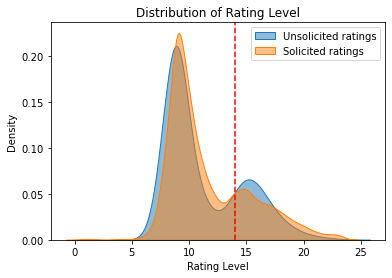

In [9]:
sns.kdeplot(sinU['numeric_rating'], label="Unsolicited ratings", fill=True, alpha=0.5)
sns.kdeplot(sinS['numeric_rating'], label="Solicited ratings", fill=True, alpha=0.5)
plt.axvline(x=14, color = 'r', linestyle = '--')
plt.xlabel('Rating Level')
plt.ylabel("Density")
plt.legend()
plt.title("Distribution of Rating Level")
plt.savefig(PROJECT_ROOT/"outputs"/ "figures" / "Rating_full.png")
plt.show()

Test of Prediction 2 and 3

In [10]:
cols_to_match = ['countryrating','ch', 'wcap', 'ROA',  'ICOV', 'LDTC', 'SDTD',  'OM',  'Z_score']
final_result[cols_to_match].describe()

,countryrating,ch,wcap,ROA,ICOV,LDTC,SDTD,OM,Z_score
count,8216.000000,3784.000000,3390.000000,3454.000000,3670.000000,3786.000000,3394.000000,3698.000000,2654.000000
mean,18.194322,235.775888,212.665757,0.029073,11.102874,0.263950,0.469758,0.132514,3.751601
std,2.609605,326.987754,530.812169,0.079623,16.956259,0.220584,0.235698,0.191682,3.628660
min,6.375000,0.000000,-1085.785167,-0.198311,-33.492338,-0.484353,0.000000,-0.433080,-7.779976
25%,16.573034,21.408628,-2.367667,0.000495,1.715981,0.101022,0.277237,0.045093,1.509529
50%,18.445312,85.313315,94.148833,0.031583,4.354679,0.224663,0.451952,0.104978,2.563087
75%,20.111111,288.856500,358.771500,0.066764,13.452087,0.374919,0.644726,0.204484,4.606030
max,23.000000,1091.200115,1442.189000,0.265570,48.660406,1.196611,1.000000,0.682657,13.895535


In [11]:
credit = final_result.copy()
credit = credit.set_index(["industrydescription","year"])

In [12]:
credit_z = credit [['numeric_rating','unsol','Z_score', 'countryrating']].copy()

X = credit_z[["unsol"]]
y = credit_z["numeric_rating"]
X = X.assign(constant=1)
model = PanelOLS(y, X, entity_effects= False, time_effects=False, check_rank=True)
result = model.fit(cov_type="clustered")
print("Solicitation only")
print(result.summary)
print("")
print("")

credit_z = credit_z.dropna()
X = credit_z[["Z_score", 'countryrating']]
y = credit_z["numeric_rating"]
X = X.assign(constant=1) 
model = PanelOLS(y, X, entity_effects=True, time_effects=True, check_rank=True)
result = model.fit(cov_type="clustered")
print("Quality only")
print(result.summary)
print("")
print("")

X = credit_z[['unsol','Z_score', 'countryrating']]
y = credit_z["numeric_rating"]
X = X.assign(constant=1) 
model = PanelOLS(y, X, entity_effects=True, time_effects=True, check_rank=True)
result = model.fit(cov_type="clustered")
print("Quality and Solicitation")
print(result.summary)

Solicitation only
                          PanelOLS Estimation Summary                           
Dep. Variable:         numeric_rating   R-squared:                        0.0008
Estimator:                   PanelOLS   R-squared (Between):             -0.0314
No. Observations:                9138   R-squared (Within):              -0.0007
Date:                Wed, Sep 03 2025   R-squared (Overall):              0.0008
Time:                        11:12:55   Log-likelihood                -2.463e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      7.0621
Entities:                          26   P-value                           0.0079
Avg Obs:                       351.46   Distribution:                  F(1,9136)
Min Obs:                       3.0000                                           
Max Obs:                       823.00   F-statistic (robust):             7.8098
          

Test of Prediction 4

In [13]:
credit = final_result.copy()
credit_spe = credit[credit['numeric_rating']<14].copy()

sinU_spe = credit_spe[credit_spe['unsol']==0]
sinS_spe = credit_spe[credit_spe['unsol']==1]


t_stat, p_value = ttest_ind(sinS_spe['Z_score'].dropna(), sinU_spe['Z_score'].dropna(), alternative='greater')
print(f"t-statistic: {t_stat}, P-value: {p_value}")
if p_value < 0.05:
    print("Reject the null hypothesis: The two distributions are significantly different.")
else:
    print("Fail to reject the null hypothesis: No significant difference in distributions.")


t-statistic: 2.084359510945733, P-value: 0.018644186485181843
Reject the null hypothesis: The two distributions are significantly different.


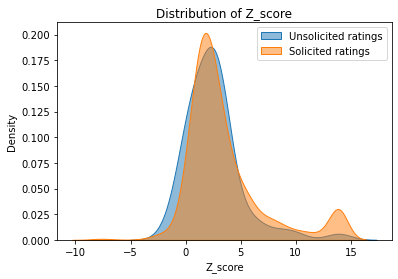

In [14]:
sns.kdeplot(sinU_spe['Z_score'].dropna(), label="Unsolicited ratings", fill=True, alpha=0.5)
sns.kdeplot(sinS_spe['Z_score'].dropna(), label="Solicited ratings", fill=True, alpha=0.5)
plt.xlabel("Z_score")
plt.ylabel("Density")
plt.legend()
plt.title("Distribution of Z_score")
plt.savefig(PROJECT_ROOT/"outputs"/ "figures" / "Z_score_speculative.png")
plt.show()

Robustness check: financial quality measures

In [15]:
cols_to_reg = ['ch','wcap',  'ROA', 'LDTC', 'SDTD', 'ICOV', 'OM', 'countryrating'] 

In [16]:
credit = final_result.copy()
regs = cols_to_reg+['unsol'] 
datas = regs + ['numeric_rating']
credit[cols_to_reg] = scaler.fit_transform(credit[cols_to_reg])
credit = credit.set_index(["industrydescription","year"])

In [17]:
credit = credit[datas].dropna()
y = credit ['numeric_rating']
X = credit[cols_to_reg]
X = X.assign(constant=1)
model = PanelOLS(y, X, entity_effects=True, time_effects=True, check_rank=True)
result = model.fit(cov_type="clustered")
print("Quality only")
print(result.summary)
print("")
print("")


y = credit ['numeric_rating']
X = credit[regs]
X = X.assign(constant=1)  
model = PanelOLS(y, X, entity_effects=True, time_effects=True, check_rank=True)
result = model.fit(cov_type="clustered")
print("Quality and Solicitation")
print(result.summary)

Quality only
                          PanelOLS Estimation Summary                           
Dep. Variable:         numeric_rating   R-squared:                        0.2735
Estimator:                   PanelOLS   R-squared (Between):             -0.2643
No. Observations:                2709   R-squared (Within):               0.2744
Date:                Wed, Sep 03 2025   R-squared (Overall):              0.2516
Time:                        11:12:56   Log-likelihood                   -6672.4
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      124.86
Entities:                          26   P-value                           0.0000
Avg Obs:                       104.19   Distribution:                  F(8,2653)
Min Obs:                       0.0000                                           
Max Obs:                       321.00   F-statistic (robust):             130.64
               

Robustness check: Industry-focused regression

In [18]:
credit = pd.read_csv(DATA / "combined_industry.csv")
credit.describe()

,gvkey,entity_id,unsol,numeric_rating,year,countryrating,ch,wcap,ROA,ICOV,LDTC,SDTD,OM,Z_score
count,822.000000,3720.000000,3720.000000,3720.000000,3720.000000,3449.000000,661.000000,35.000000,430.000000,517.000000,649.000000,51.000000,521.000000,25.000000
mean,167677.850365,428727.920968,0.947043,16.677151,2009.159677,16.413937,1343.378904,301.490628,0.015100,2.599080,0.165296,0.547028,0.456165,3.117635
std,110315.946072,121466.160676,0.223978,3.618142,5.933148,2.719833,1885.316892,891.781545,0.022183,2.684653,0.193752,0.263530,0.293612,3.503648
min,2018.000000,1894.000000,0.000000,1.000000,2000.000000,2.000000,0.180966,-1406.231758,-0.045707,-4.309140,0.000000,0.094078,-0.855017,-2.335849
25%,29945.250000,379630.000000,1.000000,15.000000,2006.000000,13.899083,112.151427,-0.985815,0.004668,1.173300,0.026701,0.370714,0.279303,1.023187
50%,203525.500000,403988.500000,1.000000,18.000000,2006.000000,17.740741,431.505881,69.496577,0.010616,1.604479,0.087348,0.503457,0.510048,2.151330
75%,265791.500000,493847.000000,1.000000,19.000000,2013.000000,17.740741,1596.116333,467.429500,0.021460,3.000780,0.225391,0.734197,0.657410,4.079077
max,359443.000000,713810.000000,1.000000,23.000000,2024.000000,23.000000,6048.011052,1872.675444,0.071836,8.483220,0.821461,1.000000,1.048887,12.352112


In [19]:
cols_to_reg = ['ch', 'ROA', 'LDTC', 'ICOV', 'OM', 'countryrating'] 

In [20]:
credit[cols_to_reg] = scaler.fit_transform(credit[cols_to_reg])

In [21]:
regs = cols_to_reg  + ['unsol'] 
credit = credit.set_index(["industrydescription","year"])

In [22]:
y = credit ['numeric_rating']
X = credit[['unsol']]
X = X.assign(constant=1)  
model = PanelOLS(y, X, entity_effects=False, time_effects=False, check_rank=True)
result = model.fit(cov_type="clustered", cluster_entity=True)
print("Solicitation only")
print(result.summary)
credit = credit.dropna(subset=regs)
print("")
print("")

y = credit ['numeric_rating']
X = credit[cols_to_reg]
X = X.assign(constant=1)  
model = PanelOLS(y, X, entity_effects=True, time_effects=True, check_rank=True)
result = model.fit(cov_type="clustered", cluster_entity=True)
print("Quality only")
print(result.summary)
print("")
print("")

y = credit ['numeric_rating']
X = credit[regs]
X = X.assign(constant=1)  
model = PanelOLS(y, X, entity_effects=True, time_effects=True, check_rank=True)
result = model.fit(cov_type="clustered", cluster_entity=True)
print("Quality and Solicitation")
print(result.summary)

Solicitation only
                          PanelOLS Estimation Summary                           
Dep. Variable:         numeric_rating   R-squared:                        0.0005
Estimator:                   PanelOLS   R-squared (Between):             -0.0626
No. Observations:                3720   R-squared (Within):              -0.0014
Date:                Wed, Sep 03 2025   R-squared (Overall):              0.0005
Time:                        11:12:57   Log-likelihood                -1.006e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1.7515
Entities:                           9   P-value                           0.1858
Avg Obs:                       413.33   Distribution:                  F(1,3718)
Min Obs:                       7.0000                                           
Max Obs:                       2662.0   F-statistic (robust):             3.6316
          

Empirical calibration

In [23]:
fee_t = pd.read_excel(DATA / 'raw'/'sp_annual'/ 'sp.xlsx')
recovery_rate = pd.read_excel(DATA / 'raw'/ 'recovery_rate.xlsx')

In [24]:
ye = []
couns = []
ratio_year = []
ratio_com = []
no_firm = []


for year in years:
    year_sin1 = pd.read_csv(DATA / "calibration" / f"{year}_whole.csv")
    year_sinS = year_sin1[year_sin1['unsol']==1]
    countries = year_sin1['countrycode'].unique()
    
    #compute intrest rate
    int_rates = []
    for index, row in year_sin1.iterrows():      
        if row.loc['lt']!= 0 and row.loc['xint'] != 0:
            int_rate = row.loc['xint']/row.loc['lt']
        else:
            int_rate = None
            
        int_rates.append(int_rate)

    year_sin1['Int_rate'] = int_rates
    recovery = recovery_rate.loc[recovery_rate['Year']==year,'Bond'].iloc[0]/100
    D = 1- recovery
    if year_sinS.shape[0] > 0:
        fee = fee_t.loc[fee_t['Date'] == year, 'RatingRevenue'].iloc[0]/year_sinS.shape[0]


        for coun in countries:
            year_sin = year_sin1[year_sin1['countrycode'] == coun] 
            non_na_counts = year_sin.count(axis=1)
            rows_with_fewer_than_50_entries = (non_na_counts < 50).sum()

            if rows_with_fewer_than_50_entries/year_sin.shape[0] > 1:
                continue
            else:

                interest_rate_whole = year_sin['Int_rate'].mean()

                inves = year_sin[year_sin['numeric_rating'] >= 14]
                specula = year_sin[year_sin['numeric_rating'] < 14]


                int_r_in = inves['Int_rate'].mean()
                int_r_sep = specula['Int_rate'].mean()

                inves_count = inves.shape[0] 
                spec_count = specula.shape[0]

                if int_r_in> int_r_sep or inves_count <= 10 or spec_count <= 10: #delete those with too few observations
                    continue

                else:

                    qbart = D/(interest_rate_whole+D)
                    dltt = year_sin['lt'].mean()
                    value_ratio = fee/((int_r_sep-int_r_in)*dltt)
                    if value_ratio<=1:
                        ratio = inves_count/spec_count
                        no_firm.append(year_sin.shape[0])
                        couns.append(coun)
                        ye.append(year)
                        ratio_year.append(ratio)
                        qprime = qbart-(1-qbart)*np.sqrt(1/value_ratio)
                        if qprime <= 0:
                            qprime = 0

                        h = 1-qbart + (qbart - qprime)*value_ratio
                        l = (qbart - qprime)*(1-value_ratio) + qprime*(2*qbart-1)/(qbart**2) 
                        ratio_hl = h/l
                        ratio_com.append(ratio_hl)

In [25]:
ratingratio = pd.DataFrame({'year': ye, 'country': couns, 'firms_count':no_firm, 'log_modelimplied_ratio': np.log(ratio_com), 'log_true_ratio':np.log(ratio_year)})
ratingratio = ratingratio.dropna()
ratingratio = ratingratio[~ratingratio.isin([-np.inf]).any(axis=1)]

In [26]:
ratingratio.set_index(['country', 'year'], inplace=True)

In [27]:
model = PanelOLS.from_formula('log_true_ratio ~ 1 + log_modelimplied_ratio + EntityEffects + TimeEffects', data=ratingratio)
results = model.fit()
print(results)

                          PanelOLS Estimation Summary                           
Dep. Variable:         log_true_ratio   R-squared:                        0.0301
Estimator:                   PanelOLS   R-squared (Between):             -0.0798
No. Observations:                 304   R-squared (Within):              -0.0828
Date:                Wed, Sep 03 2025   R-squared (Overall):             -0.1265
Time:                        11:13:10   Log-likelihood                    205.62
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      7.8151
Entities:                          31   P-value                           0.0056
Avg Obs:                       9.8065   Distribution:                   F(1,252)
Min Obs:                       1.0000                                           
Max Obs:                       21.000   F-statistic (robust):             7.8151
                            